In [1]:
from datetime import datetime

startTime = datetime(2023,1,27, 9)
endTime = datetime(2023,2,8, 10)

In [2]:
import pandas as pd
import numpy as np
import talib as ta
import os
import matplotlib.pyplot as plt
import warnings
import pymongo
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats, signal
warnings.filterwarnings('ignore')

In [3]:
def prepareData(collection, startTime, endTime, rsPeriod):
    data_df = pd.DataFrame(
        list(collection.find({"datetime": {'$gt': startTime, '$lt': endTime}}))
    )
    data = data_df[['datetime', 'open', 'high', 'low', 'close', 'volume']].copy()
    hlcvDict = {'open':'first', 'high':'max', 'low':'min', 'close': 'last','volume':'sum'}
    data = data.set_index('datetime')
    dataDf = data.resample(rsPeriod).apply(hlcvDict)
    dataDf = dataDf.dropna()
    return dataDf

symbol1 = 'btc_usdt.spot:binance'
symbol2 = 'eth_usdt.spot:binance'

client = pymongo.MongoClient('172.16.20.81', 27017)
collection1 = client['Kline_1Min_Auto_Db_Plus'][symbol1]
collection2 = client['Kline_1Min_Auto_Db_Plus'][symbol2]



dataBtc15Min = prepareData(collection1, startTime, endTime, '15Min')
dataBtcDay = prepareData(collection1, startTime, endTime, 'D')
dataEth15Min = prepareData(collection2, startTime, endTime, '15Min')
dataEthDay = prepareData(collection2, startTime, endTime, 'D')

In [4]:
dataBtcPv = dataBtc15Min[['close', 'volume']]
dataEthPv = dataEth15Min[['close', 'volume']]

In [5]:
# dataEthPv

In [6]:
dataBtcPvDf = dataBtcPv.set_index('close').sort_index()
dataEthPvDf = dataEthPv.set_index('close').sort_index()

In [19]:
def cal_resistance_surport(dataPv):
    kde_factor = 0.05
    num_samples = 5000
    kde = stats.gaussian_kde(dataPv.close.values,weights=dataPv.volume.values, bw_method=kde_factor)
    xr = np.linspace(dataPv.close.min(),dataPv.close.max(),num_samples)
    kdy = kde(xr)
    ticks_per_sample = (xr.max() - xr.min()) / num_samples
    min_prom = kdy.max() * 0.75
    width_range= 1
    peaks, peak_props = signal.find_peaks(kdy, prominence=min_prom, width=width_range, rel_height=0.75)
    left_ips = peak_props['left_ips']
    right_ips = peak_props['right_ips']
    pkx = xr[peaks]
    pky = kdy[peaks]
    width_x0 = xr.min() + (left_ips * ticks_per_sample)
    width_x1 = xr.min() + (right_ips * ticks_per_sample)
    return round(pkx[0], 2), round(width_x0[0], 2), round(width_x1[0], 2)

In [20]:
dataBtcPv

,close,volume
datetime,,
2023-01-27 09:00:00,22953.48,1726.69960
2023-01-27 09:15:00,22893.29,2650.25585
2023-01-27 09:30:00,22671.05,8677.05477
2023-01-27 09:45:00,22643.42,4876.33152
2023-01-27 10:00:00,22735.99,3570.24557
...,...,...
2023-02-08 08:45:00,23326.40,3539.75590
2023-02-08 09:00:00,23376.16,4281.16971
2023-02-08 09:15:00,23313.16,3520.10345


In [21]:
week15Min = 672
pocBtc, SupportBtc, ResistanceBtc = cal_resistance_surport(dataBtcPv.iloc[-week15Min:])
pocEth, SupportEth, ResistanceEth = cal_resistance_surport(dataEthPv.iloc[-week15Min:])

In [22]:
btcVolumeProfile = pd.DataFrame({'btcVolumeProfile': ('Point Of Control', 'Support', 'Resistance'),
'weekly_btc': (pocBtc, SupportBtc, ResistanceBtc)
})

ethVolumeProfile = pd.DataFrame({'ethVolumeProfile': ('Point Of Control', 'Support', 'Resistance'),
'weekly_eth': (pocEth, SupportEth, ResistanceEth)
})

In [23]:
btcVolumeProfileDf = btcVolumeProfile.set_index('btcVolumeProfile').T
ethVolumeProfileDf = ethVolumeProfile.set_index('ethVolumeProfile').T

In [24]:
btcVolumeProfileDf.to_excel('btcVolumeProfileDf.xlsx')
ethVolumeProfileDf.to_excel('ethVolumeProfileDf.xlsx')

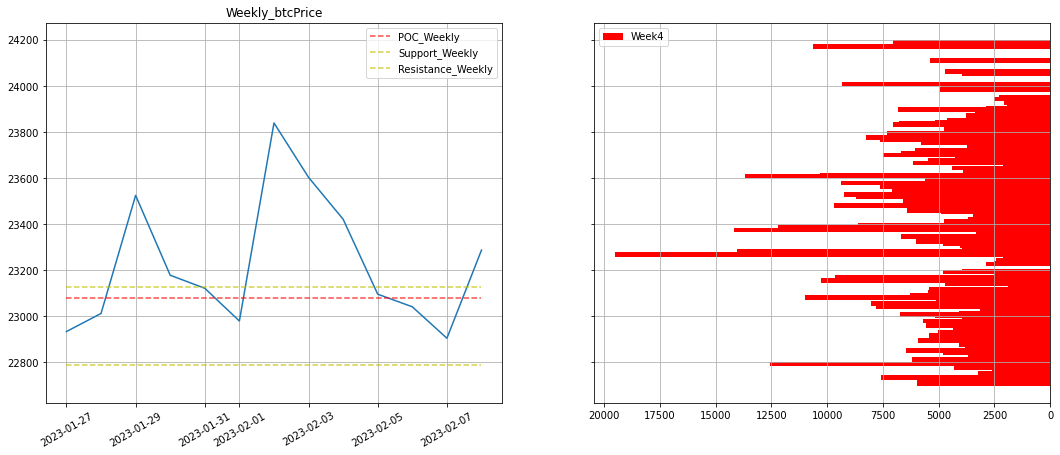

In [25]:
fBtc, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,7))
# ax1.figure(figsize=(15, 7))
# ax1.barh(dataBtcPv.close, dataBtcPv.volume, height=90, color='g')
ax1.set_title('Weekly_volumeProfile')
ax1.plot(dataBtcDay.close)
ax1.hlines(pocBtc, dataBtcDay.index[0], dataBtcDay.index[-1] , linestyles='dashed', alpha=0.7, color='r', label='POC_Weekly')
ax1.hlines(SupportBtc, dataBtcDay.index[0], dataBtcDay.index[-1] , linestyles='dashed', alpha=0.7, color='y', label='Support_Weekly')
ax1.hlines(ResistanceBtc, dataBtcDay.index[0], dataBtcDay.index[-1] , linestyles='dashed', alpha=0.7, color='y', label='Resistance_Weekly')
ax1.legend()
ax1.set_title('Weekly_btcPrice')
ax1.grid()
# ax2.set_xticklabels(dataEthDay.index.day, rotation=15)
for tick in ax1.get_xticklabels():
    tick.set_rotation(30)
ax2.barh(dataBtcPv.close.iloc[-672:], dataBtcPv.volume.iloc[-672:], height=20, color='red', label='Week4')
ax2.grid()
ax2.invert_xaxis()
ax2.legend()
fBtc.savefig('btcVolumeProfile')

NameError: name 'pocEth4' is not defined

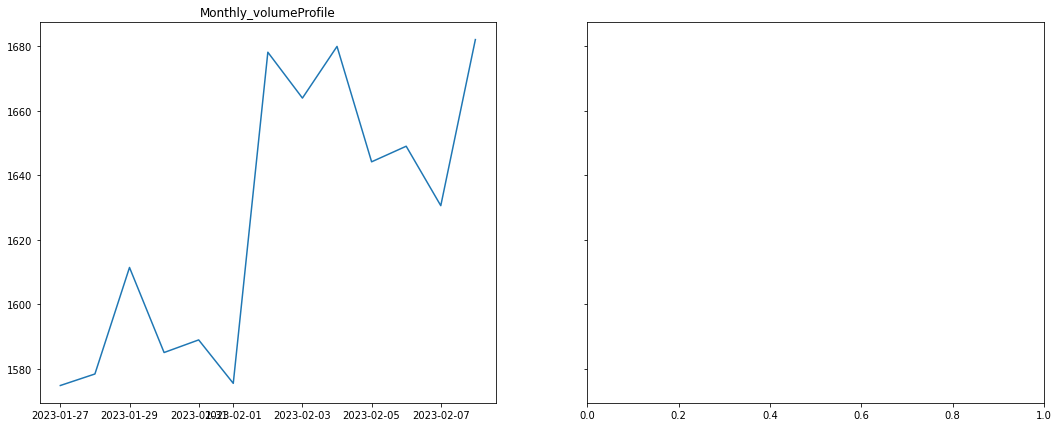

In [26]:
fEth, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(18,7))
# ax1.figure(figsize=(15, 7))
# ax1.barh(dataEthPv.close, dataEthPv.volume, height=90, color='g')
ax1.set_title('Monthly_volumeProfile')
ax1.plot(dataEthDay.close)
ax1.hlines(pocEth4, dataEthDay.index[0], dataEthDay.index[-1] , linestyles='dashed', alpha=0.7, color='red', label='POC_Week4')
ax1.hlines(pocEth3, dataEthDay.index[0], dataEthDay.index[-1] , linestyles='dashed', alpha=0.7, color='orange', label='POC_Week3')
ax1.hlines(pocEth2, dataEthDay.index[0], dataEthDay.index[-1] , linestyles='dashed', alpha=0.7, color='yellow', label='POC_Week2')
ax1.hlines(pocEth1, dataEthDay.index[0], dataEthDay.index[-1] , linestyles='dashed', alpha=0.7, color='g', label='POC_Week1')
ax1.legend()
ax1.set_title('Monthly_ethPrice')
ax1.grid()
# ax2.set_xticklabels(dataEthDay.index.day, rotation=15)
for tick in ax1.get_xticklabels():
    tick.set_rotation(30)
ax2.barh(dataEthPv.close.iloc[-672:], dataEthPv.volume.iloc[-672:], height=6, color='red', label='Week4')
ax2.barh(dataEthPv.close.iloc[-672*2:-672], dataEthPv.volume.iloc[-672*2:-672], height=6, color='orange', label='Week3')
ax2.barh(dataEthPv.close.iloc[-672*3:-672*2], dataEthPv.volume.iloc[-672*3:-672*2], height=6, color='yellow', label='Week2')
ax2.barh(dataEthPv.close.iloc[-672*4:-672*3], dataEthPv.volume.iloc[-672*4:-672*3], height=6, color='g', label='Week1')
ax2.grid()
ax2.invert_xaxis()
ax2.legend()
fEth.savefig('ethVolumeProfile')